# Feature engineering with Lasso model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
%matplotlib inline

In [2]:
train = pd.read_csv("../input/train.csv", index_col=0)
test = pd.read_csv("../input/test.csv", index_col=0)

In [3]:
y_train = train['SalePrice']
new_y_train = y_train.copy()

In [4]:
merged = pd.concat([train.iloc[:, :-1], test], axis=0)
merged['MSSubClass'] = merged['MSSubClass'].astype(str)

In [5]:
train_index = train.index.copy()

# Numeric Features

In [6]:
merger_num = merged.select_dtypes(exclude=['object'])

In [7]:
print(merger_num.columns.size)
merger_num.columns

35


Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [8]:
merger_num.isnull().sum().sort_values(ascending=False).head(11)

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
BsmtFinSF1        1
GarageArea        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
GarageCars        1
dtype: int64

## Fix null

### LotFrontage

In [9]:
train.shape, y_train.shape

((1460, 80), (1460,))

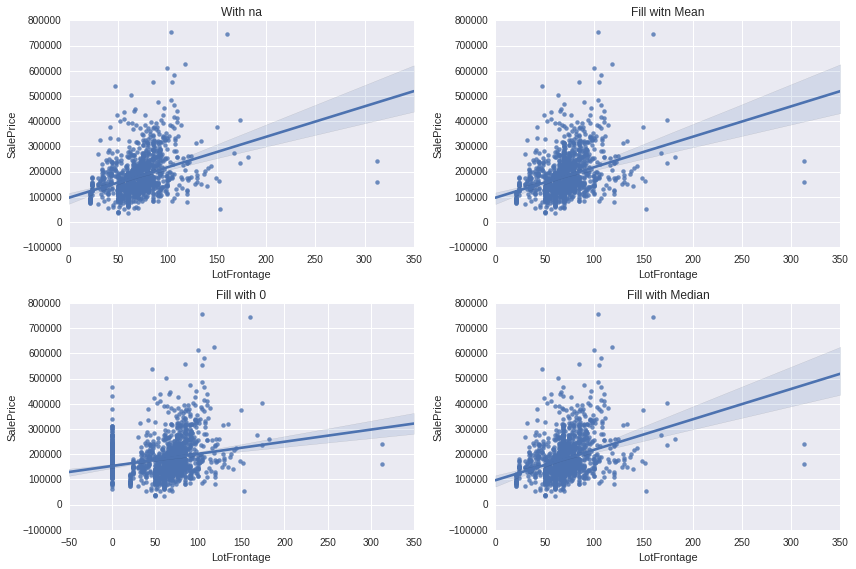

In [10]:
# set null values to mean
plt.figure(figsize=[12, 8])

plt.subplot(2, 2, 1)
plt.title("With na")
sns.regplot(train.LotFrontage, y_train)

plt.subplot(2, 2, 2)
plt.title("Fill witn Mean")
sns.regplot(train.LotFrontage.fillna(train.LotFrontage.mean()), y_train)

plt.subplot(2, 2, 3)
plt.title("Fill with 0")
sns.regplot(train.LotFrontage.fillna(0), y_train)

plt.subplot(2, 2, 4)
plt.title("Fill with Median")
sns.regplot(train.LotFrontage.fillna(train.LotFrontage.median()), y_train)

plt.tight_layout()

In [11]:
# clearly filling with 0 gives a lot of noise. mean, median almost same! fill with mean
merged.LotFrontage.mean(), merged.LotFrontage.median()

(69.30579531442663, 68.0)

In [12]:
# filling with mean
merged.LotFrontage.fillna(train.LotFrontage.mean(), inplace=True)
# high skew, log does not solve problem, remove outliers
print('before: ', merged.shape)
split_train = merged.loc[train.index]
split_test = merged.loc[test.index]
out_pos = split_train['LotFrontage'].mean() + 3 * split_train['LotFrontage'].std()
split_train = split_train[split_train.LotFrontage < out_pos]
train_index = split_train.index.copy()
merged = pd.concat([split_train, split_test], axis=0)
print('after: ', merged.shape)

before:  (2919, 79)
after:  (2903, 79)


In [13]:
new_y_train = y_train.loc[train_index]

### MasVnrArea

In [14]:
# replace with mean, as median is 0
merged.MasVnrArea.fillna(merged.MasVnrArea.mean(), inplace=True)
# high skew in data, use log
print('before: ', skew(merged.MasVnrArea))
merged['MasVnrArea'] = np.log1p(merged['MasVnrArea'])
print('after: ', skew(merged.MasVnrArea))

before:  2.6127374304815305
after:  0.4995545833942213


### Others

In [15]:
other_cols = merger_num.isnull().sum().sort_values(ascending=False).head(11).index[3:]
# replace na these 0
for i in np.arange(other_cols.size):
    merged[other_cols[i]].fillna(0, inplace = True)

In [16]:
for i in np.arange(other_cols.size):
    merged[other_cols[i]] = np.log1p(merged[other_cols[i]])

In [17]:
GarageYrBlt_naIndex = merged[merged.GarageYrBlt.isnull()].index
for i in GarageYrBlt_naIndex:
    merged.GarageYrBlt.set_value(i, merged.YearBuilt.get_value(i))

## Dimensionality Reduction

In [18]:
merger_num.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [19]:
# add the two flr area to one, then drop both
merged['TotalSF'] = merged['1stFlrSF'] + merged['2ndFlrSF']
merged.drop(['1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)
# TotalSF has high skew
print('before: ', skew(merged['TotalSF']))
merged['TotalSF'] = np.log(merged['TotalSF'])
print('after: ', skew(merged['TotalSF']))

In [97]:
# merge fullbath and halfbath
merged['FullBath'] = merged['FullBath'] + merged['BsmtFullBath']
merged['HalfBath'] = merged['HalfBath'] + merged['BsmtHalfBath']
merged.drop(['BsmtFullBath', 'BsmtHalfBath'], axis=1, inplace=True)

# Lasso 

In [100]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.cross_validation import cross_val_score

In [101]:
scrorer = make_scorer(mean_squared_error, greater_is_better=False)

In [102]:
def run_lasso(xt, yt, xtst, param_grid, rs=999, cv=5, verbose=0):
    lasso = Lasso(random_state=rs)
    grid_CV = GridSearchCV(n_jobs=-1, estimator=lasso, cv=cv, scoring=scrorer, param_grid=param_grid, verbose=verbose)
    
    grid_CV.fit(xt, yt)
    py = grid_CV.predict(xtst)
    
    return grid_CV

In [103]:
dummy = pd.get_dummies(merged)

In [104]:
train_X = dummy.loc[train_index]
test_X = dummy.loc[test.index]
test_X.shape, train_X.shape, train.shape

((1459, 299), (1444, 299), (1460, 80))

In [149]:
lasso = Lasso(random_state=999, max_iter=5e4)
alpha = np.linspace(60e-5, 61e-5, 100)
params = {'alpha' : alpha}
grid_CV = GridSearchCV(n_jobs=-1, estimator=lasso, cv=2, scoring=scrorer, param_grid=params, verbose=1)

In [150]:
grid_CV.fit(train_X, np.log(new_y_train))

Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   10.9s finished


GridSearchCV(cv=2, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=50000.0,
   normalize=False, positive=False, precompute=False, random_state=999,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'alpha': array([ 0.0006 ,  0.0006 , ...,  0.00061,  0.00061])},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(mean_squared_error, greater_is_better=False),
       verbose=1)

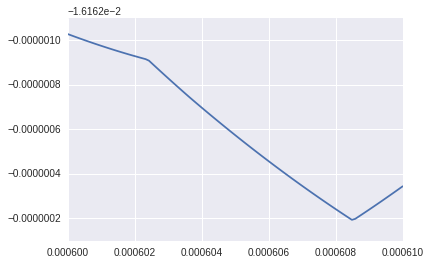

In [151]:
pred_y = grid_CV.predict(test_X)
plt.gca().invert_yaxis()
pd.Series([score[1] for score in grid_CV.grid_scores_], index=alpha).plot()

In [153]:
print(grid_CV.best_params_)
# grid_CV.grid_scores_

{'alpha': 0.00060848484848484842}


# View Lasso coff

In [155]:
log_y = np.log(new_y_train)

In [156]:
lasss_coff = Lasso(alpha = grid_CV.best_params_['alpha'], max_iter=5e5).fit(train_X, log_y)

In [157]:
coff = pd.Series(lasss_coff.coef_, index=train_X.columns).sort_values(ascending=False)

In [190]:
# non zero features
cut = pd.cut(coff[coff != 0], 9, labels=['{}'.format(x) for x in [5, 4, 3, 2, 1, -2, -3, -4, -5]])
cut[cut == '1']

ExterCond_TA            1
Exterior1st_MetalSd     1
Neighborhood_ClearCr    1
HalfBath                1
BsmtFinSF1              1
MSSubClass_70           1
MasVnrType_Stone        1
FireplaceQu_Gd          1
MSZoning_RL             1
MSZoning_FV             1
LandSlope_Mod           1
Alley_Pave              1
GarageType_Detchd       1
TotRmsAbvGrd            1
HouseStyle_1Story       1
GarageArea              1
LotConfig_Corner        1
GarageType_Attchd       1
YearBuilt               1
BsmtFinType1_GLQ        1
YearRemodAdd            1
LotFrontage             1
GarageYrBlt             1
ScreenPorch             1
PoolArea                1
GrLivArea               1
EnclosedPorch           1
WoodDeckSF              1
LowQualFinSF            1
3SsnPorch               1
                       ..
GarageQual_Fa           1
MSSubClass_30           1
Neighborhood_Gilbert    1
GarageFinish_Unf        1
YrSold                  1
BsmtUnfSF               1
HeatingQC_TA            1
Foundation_B

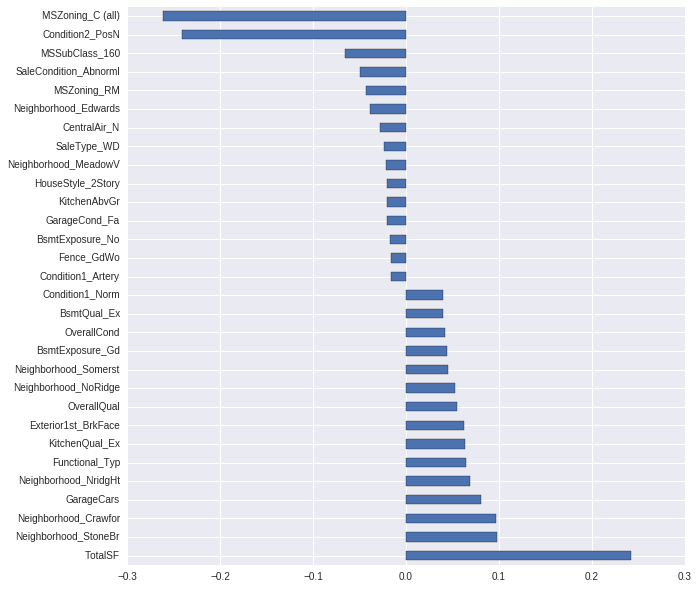

In [165]:
imp_features = pd.concat([coff.head(15), coff.tail(15)], axis=0)
plt.figure(figsize=[10, 10])
imp_features.plot(kind='barh')